In This notebook, we load and investigate the S11 Measurements on the Greenbank feed.

In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal as signal
import scipy.optimize as op
import aipy
import sys,csv

In [12]:
#First load in the data
dFile1='HERA_Dish1_S11_feed4_0m_A.d1'
dFile2='HERA_Dish1_S11_feed4_5m_A.d1'
dFile3='HERA_Dish1_S11_feed5_0m_A.d1'
dFile4='HERA_Dish1_S11_feed5_3m_A.d1'
dFileOld='Data03.d1'
dFile5='S11_adapterOnly.d1'
dFileFeedOnly='../FeedOnly/DATA02.d1'
d1=np.loadtxt(dFile1,skiprows=9,delimiter=',')[:-1,:]
d2=np.loadtxt(dFile2,skiprows=9,delimiter=',')[:-1,:]
d3=np.loadtxt(dFile3,skiprows=9,delimiter=',')[:-1,:]
d4=np.loadtxt(dFile4,skiprows=9,delimiter=',')[:-1,:]
d5=np.loadtxt(dFileOld,skiprows=9,delimiter=',')[:-1,:]
d6=np.loadtxt(dFile5,skiprows=9,delimiter=',')[:-1,:]
d7=np.loadtxt(dFileFeedOnly,skiprows=9,delimiter=',')[:-1,:]
d4m=d1[:,0]+1j*d1[:,1]
d4p5m=d2[:,0]+1j*d2[:,1]
d5m=d3[:,0]+1j*d3[:,1]
d5p3m=d4[:,0]+1j*d4[:,1]
dAdapt=d6[:,0]+1j*d6[:,1]
dOld=d5[:,0]+1j*d5[:,1]
dFeed=d7[:,0]+1j*d7[:,1]

#np.savetxt('amp_s11.txt',20.*np.log10(np.abs(d4m)))
#np.savetxt('phs_s11.txt',np.unwrap(np.angle(d4m))*180./np.pi)
freqAxis=100e6+np.arange(1600)*100e6/1600
#np.savetxt('frq_s11.txt',freqAxis/1e9)

Reading ../../DishReflectometry/alldata/NC41_12_DB.csv
Reading ../../DishReflectometry/alldata/NC41_12_P.csv
Reading Daisy file  ../../DishReflectometry/plots/Time/set1/TXT102.csv
[[ -2.00000000e+04   2.04790000e-04   8.38520000e+01]
 [ -1.88950000e+04   3.65320000e-04  -1.78840000e+02]
 [ -1.77890000e+04   3.37280000e-04  -1.71200000e+02]
 ..., 
 [  4.19894000e+05   6.58240000e-02  -1.52850000e+02]
 [  4.21000000e+05   4.01830000e-01   7.95820000e+01]
 [  4.22105000e+05   4.13410000e-01  -7.18850000e+01]]
Reading Daisy file  ../../DishReflectometry/plots/Freq/set1/TXT101.csv
[[  5.00000000e+07   8.27370000e-01  -1.05210000e+02]
 [  5.23750000e+07   8.36680000e-01  -1.09600000e+02]
 [  5.47500000e+07   8.43390000e-01  -1.13910000e+02]
 ..., 
 [  9.95250000e+08   6.07060000e-01  -2.97590000e+01]
 [  9.97625000e+08   6.08090000e-01  -2.99690000e+01]
 [  1.00000000e+09   5.92970000e-01  -2.93650000e+01]]


(-30, 300)

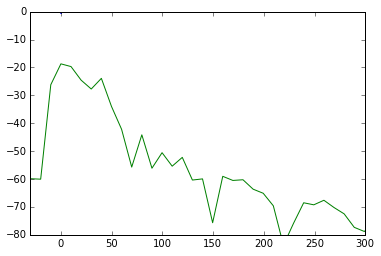

In [13]:
#nipanjanas code
#! /usr/bin/env python


def fromcsv(filename):
    print 'Reading', filename
    d = csv.reader(open(filename,'r'), delimiter=',')
    x = np.array(list(d)[18:-1], dtype=np.float)
    return x[:,0]/1e9, x[:,1]

def fromcsvdaisy_time(filename):
    ''' Returns delay(ps), power(dB) '''
    print 'Reading Daisy file ', filename
    d = csv.reader(open(filename, 'r'), delimiter=',')
    x = np.array(list(d)[12:-1], dtype=np.float)
    print x
    return x[:,0]*1e-3, 20.0*np.log10(x[:,1])

def fromcsvdaisy_freq(filename):
    ''' Returns delay(ps), power(dB) '''
    print 'Reading Daisy file ', filename
    d = csv.reader(open(filename, 'r'), delimiter=',')
    x = np.array(list(d)[12:-1], dtype=np.float)
    print x
    return x[:,0]/1e9, 20.0*np.log10(x[:,1]), x[:,2]

def take_delay(db, ph, fq, window='blackman-harris'):
    '''Take reflectometry data in dB and phase to return delay transform.
       Returns windowed and non windowed delay spectra for input spectrum.'''
    d = 10**(db/20) * np.exp(2j*np.pi*ph/360)
    tau = np.fft.fftfreq(fq.size, fq[1]-fq[0])
    window = aipy.dsp.gen_window(fq.size, window)
    _d = np.fft.ifft(d)
    _dw = np.fft.ifft(d*window) / window.mean() #compensate for window amplitude
    
    if True:
    #if False:
        
        _dw *= ( np.abs(_dw[0])/ (1- np.abs(_dw[0])))  # these should be changed to the dc bin of the windowed data.
        _d *= ( np.abs(_d[0])/ (1- np.abs(_d[0])))  # these should be changed to the dc bin of the windowed data.

    return np.fft.fftshift(_dw), np.fft.fftshift(_d), np.fft.fftshift(tau)


colors = np.array([(31,119,180), (255,127,14), (44,160,44), (214,39,40), (148,103,189)])/255.

#file_base = sys.argv[1]
path='../../DishReflectometry/'
file_base = path+'alldata/NC41_12'
amp = '_DB.csv'
phs = '_P.csv'
dfile_time = path+'plots/Time/set1/TXT102.csv'
dfile_freq= path+'plots/Freq/set1/TXT101.csv'
fq, amps = fromcsv(file_base + amp)
fq, phs= fromcsv(file_base + phs)
dns, ddb = fromcsvdaisy_time(dfile_time)
dfreq, dfreqdb, dphs = fromcsvdaisy_freq(dfile_freq)

valids = {
          '50 - 250 MHz'  : np.where(np.logical_and(fq>.05 ,fq<.25)), 
          '100 - 200 MHz' : np.where(np.logical_and(fq>.1 ,fq<.2)), 
          '140 - 160 MHz' : np.where(np.logical_and(fq>.140 ,fq<.160)),
          'no cage: 50 - 1000 MHz' : None,
          'no cage: 100 - 200 MHz' : np.where(np.logical_and(dfreq>.1, dfreq<.2))
          #'100 - 200 MHz (no cage)' : n.ones(len(dfreq), dtype=n.bool)#n.where(n.logical_and(dfreq>.1, dfreq<.2))
#          'second' : n.where(n.logical_and(fq>.250 ,fq<.500))
         }
selection=valids['100 - 200 MHz']
dUCB=np.exp(1j*np.pi/180.*phs[selection])*10.**(amps[selection]/20.)
freqsUCB=fq[selection]*1e9
plt.plot(fq[selection],dUCB)
dw,d,tau=take_delay(amps[selection],phs[selection],fq[selection],window='hamming')
plt.plot(tau,20.*np.log10(dw))
plt.ylim(-80,0)
plt.xlim(-30,300)


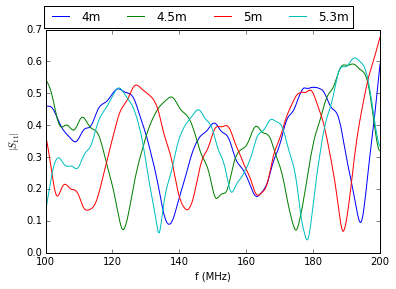

In [14]:
plt.close()
#plt.plot(freqAxis/1e6,np.sqrt(np.abs(d2[:,0])**2.+np.abs(d2[:,1])**2.),label='abs')
l1=plt.plot(freqAxis/1e6,np.abs(d4m),label='4m')[0]
l2=plt.plot(freqAxis/1e6,np.abs(d4p5m),label='4.5m')[0]
l3=plt.plot(freqAxis/1e6,np.abs(d5m),label='5m')[0]
l4=plt.plot(freqAxis/1e6,np.abs(d5p3m),label='5.3m')[0]
#l5=plt.plot(UCBfreq/1e6,np.abs(dUCB),label='UCB')[0]
plt.axhline(0,color='k',ls='--')
plt.xlabel('f (MHz)')
plt.gcf().legend((l1,l2,l3,l4),('4m','4.5m','5m','5.3m','UCB'),loc='upper center',ncol=4)#plt.plot(freqAxis/1e6,.35+.1*np.sin(2*np.pi*freqAxis*30e-9))
#plt.gcf().legend((l1,l2,l3,l4,l5),('4m','4.5m','5m','5.3m','UCB'),loc='upper center',ncol=4)#plt.plot(freqAxis/1e6,.35+.1*np.sin(2*np.pi*freqAxis*30e-9))
plt.ylabel('$|S_{11}|$')
#plt.savefig('../writeup/figures/s11_4m.pdf')
plt.show()

In [15]:
def fft1d(data):
    return fft.fftshift(fft.fft(fft.fftshift(data)))



0.159554583345
0.22346334997
gAUCB=0.22
0.0833578402105
0.112813982558
[-0.08282054+0.00944924j]
gA=0.16
gD=0.12
gDUCB=0.16
[ 0.44951557  0.88114957]


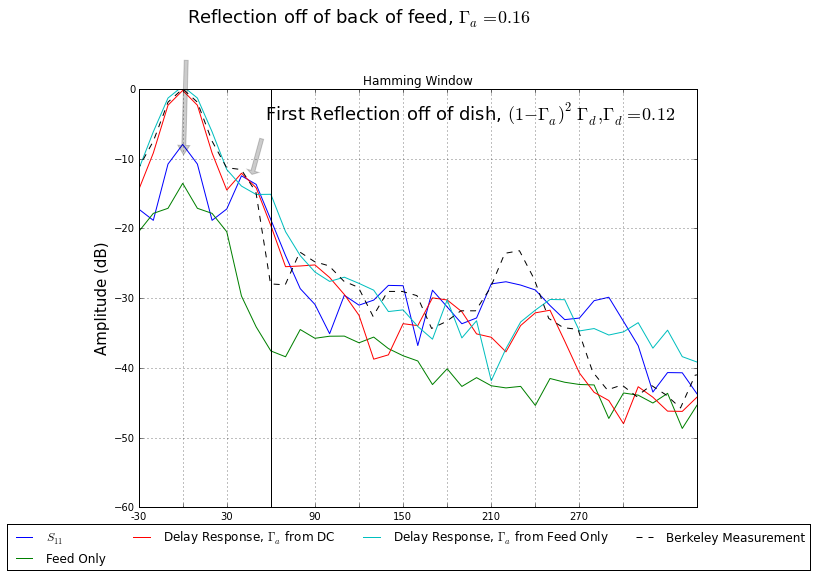

In [24]:
def fft1d_pad(data):
    window=signal.blackmanharris(len(data))
    window=np.hamming(len(data))
    window=window/np.mean(window)
    dw=data*window
    #dw=np.pad(dw,((len(data),0)),mode='constant')
    return fft.fftshift(fft.ifft(np.abs(dw)**2.))
#first, let's play around with the fft
delayAxis=fft.fftshift(fft.fftfreq(len(d5m),100e6/1601.))
delays=fft.fftshift(fft.fftfreq(d2.shape[0],100e6/1601.))
delaysUCB=fft.fftshift(fft.fftfreq(dUCB.shape[0],freqsUCB[1]-freqsUCB[0]))
d5mFT=fft1d_pad(d5m)
UCBFT=fft1d_pad(dUCB)
feedFT=fft1d_pad(dFeed)
#let's find gamma_a and the dish

def windowedMax(data,select):
    dWindow=data[select]
    maxVal=np.abs(dWindow).max()
    print maxVal
    return data[np.abs(data)==maxVal]

selectGa=np.abs(delayAxis)<10e-9
selectUCB=np.abs(delaysUCB)<10e-9
gA=np.abs(windowedMax(d5mFT,selectGa))
gAUCB=np.abs(windowedMax(UCBFT,selectUCB))
print 'gAUCB=%.2f'%np.abs(gAUCB)
selectPeak=np.logical_and(delayAxis>10e-9,delayAxis<40e-9)
selectPeakUCB=np.logical_and(delaysUCB>10e-9,delaysUCB<40e-9)
gPeak=windowedMax(d5mFT,selectPeak)
gPeakUCB=windowedMax(UCBFT,selectPeakUCB)
print gPeak
gD=np.abs(gPeak/(1.-gA)**2.)
gDUCB=np.abs(gPeakUCB/(1.-gA)**2.)

print 'gA=%.2f'%np.abs(gA)
print 'gD=%.2f'%np.abs(gD)
print 'gDUCB=%.2f'%np.abs(gDUCB)
#gD=.8
tConst=np.abs(gD*gA)


#now let's try correcting
d5mC=((d5m-gA)*gA/(1.-gA)+1.-gA)
FTd5mC=fft1d_pad(d5mC)
d5mCOld=((d5m))*gA/(1.-gA)
FTd5mCOld=fft1d_pad(d5mCOld)
dUCBC=((dUCB-gAUCB)*gAUCB/(1.-gAUCB)+1.-gAUCB)
UCBFTC=fft1d_pad(dUCBC)
dUCBCOld=dUCB*gAUCB/(1.-gAUCB)
UCBFTCOld=fft1d_pad(dUCBCOld)

feedCorrected=(d5m-dFeed)*dFeed/(1.-dFeed)+1.-dFeed
FTfeedCorrected=fft1d_pad(feedCorrected)


fitSelect=np.logical_and(delayAxis>60e-9,delayAxis<120e-9)
fitDelays=delayAxis[fitSelect]
fitVals=np.abs(FTd5mC)[fitSelect]
gDFit,_=op.curve_fit(lambda x,a,b: a*b**x,(fitDelays-30e-9)/30e-9,fitVals,p0=[1.,np.abs(gA*gD)])
print np.abs(gDFit/gA)

#lm1=plt.plot(delayAxis*1e9,20*np.log10(np.abs(gDFit[0]*(gDFit[1]**((delayAxis-30e-9)/30e-9)))),':',color=[.3,.3,.3])
#l0=plt.plot(delayAxis*1e9,20.*np.log10(np.abs((1-gA))*tConst**((delayAxis)/28e-9)),color=[.5,.5,.5])[0]
l1=plt.plot(delayAxis*1e9,10*np.log10(np.abs(d5mFT)),'-')[0]
l2=plt.plot(delayAxis*1e9,10*np.log10(np.abs(feedFT)))[0]
l3=plt.plot(delayAxis*1e9,10*np.log10(np.abs(FTd5mC)))[0]
l4=plt.plot(delayAxis*1e9,10*np.log10(np.abs(FTfeedCorrected)))[0]
#l5=plt.plot(delayAxis*1e9,20*np.log10(np.abs(FTd4mCOld)))[0]
#l5=plt.plot(delaysUCB*1e9,20*np.log10(np.abs(UCBFT)),'--',color='b')[0]
l5=plt.plot(delaysUCB*1e9,10*np.log10(np.abs(UCBFTC)/np.abs(UCBFTC).max()),'--',color='k')[0]
#l5=plt.plot(delaysUCB*1e9,20*np.log10(np.abs(UCBFTCOld)),'--',color='k')[0]
plt.ylim(-60,0)
#plt.yscale('log')
plt.xlim(-30,350)
plt.axhline(-60,color='k')
plt.axvline(60,color='k')
plt.gcf().legend((l1,l2,l3,l4,l5),('$S_{11}$','Feed Only','Delay Response, $\\Gamma_a$ from DC','Delay Response, $\\Gamma_a$ from Feed Only','Berkeley Measurement'),loc='lower center',ncol=4)
plt.xlabel('$\\tau$(ns)',fontsize=15)
plt.ylabel('Amplitude (dB)',fontsize=15)
plt.gca().set_xticks(np.arange(-30,330,30))
labels=[]
ax=plt.gca()
for mm in range(len(plt.gca().get_xticks())):
    if(np.mod(mm,2)==0):
        labels.append(str(ax.get_xticks()[mm]))
    else:
        labels.append('')
ax.set_xticklabels(labels)
plt.grid()
plt.grid(b=True,which='minor')
ax.annotate('Reflection off of back of feed, $\\Gamma_a=%.2f$'%(np.abs(gA)), xy=(0, 20.*np.log10(.2)), xytext=(3, 20.*np.log10(3)),
            arrowprops=dict(facecolor='black', shrink=0.2,alpha=.2), fontsize=18
            )
ax.annotate('First Reflection off of dish, $(1-\\Gamma_a)^2 \\Gamma_d,\\Gamma_d=%.2f$'%(np.abs(gD)), xy=(45, 20*np.log10(.2)), xytext=(56, 20.*np.log10(.6)),
            arrowprops=dict(facecolor='black', shrink=0.2,alpha=.2), fontsize=18
            )
#predicted slow is .23*0.1 every 30 ns
#plt.gcf().legend((l1,l2,l3),('|$S_{11}$|','$(\\Gamma_a \\Gamma_d)^{(\\tau/30 ns)}$','Response Function'),'lower right')
#plt.legend((l1,l2,l3,l0),('|$S_{11}$|','Response Function','No DC term','Predicted Slope from Dish Amplitude','Fitted Slope \\Gamma_d = %.2f'%(gDFit[1]/np.abs(gA))),'center right',fontsize=14)
plt.gcf().set_size_inches([10,7.5])
plt.title('Hamming Window')
#plt.savefig('../writeup/figures/reflectometry_wFeed_hamming.pdf')

0.14711098182
0.324673279245
gAUCB=0.32
0.178799268427
0.245676560878
[-0.17878427-0.00231575j]
gA=0.15
gD=0.25
gDUCB=0.34
[ 0.07927129  1.82409309]


/Users/aaronew/default/lib/python2.7/site-packages/ipykernel/__main__.py:61: RuntimeWarning: invalid value encountered in power


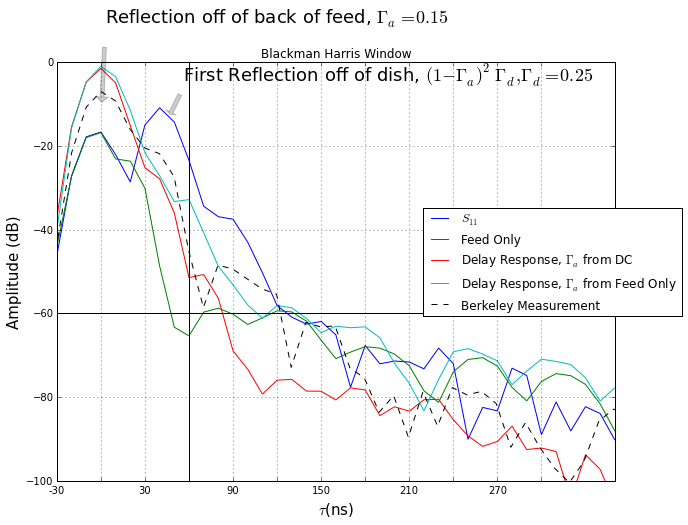

In [17]:
def fft1d_pad(data):
    window=signal.blackmanharris(len(data))
    #window=np.hamming(len(data))
    window=window/np.mean(window)
    dw=data*window
    #dw=np.pad(dw,((len(data),0)),mode='constant')
    return fft.fftshift(fft.ifft((dw)))

#first, let's play around with the fft
delayAxis=fft.fftshift(fft.fftfreq(len(d5m),100e6/1600.))
delays=fft.fftshift(fft.fftfreq(d2.shape[0],100e6/1600.))
delaysUCB=fft.fftshift(fft.fftfreq(dUCB.shape[0],freqsUCB[1]-freqsUCB[0]))
d5mFT=fft1d_pad(d5m)
UCBFT=fft1d_pad(dUCB)
feedFT=fft1d_pad(dFeed)
#let's find gamma_a and the dish

def windowedMax(data,select):
    dWindow=data[select]
    maxVal=np.abs(dWindow).max()
    print maxVal
    return data[np.abs(data)==maxVal]

selectGa=np.abs(delayAxis)<10e-9
selectUCB=np.abs(delaysUCB)<10e-9
gA=np.abs(windowedMax(d5mFT,selectGa))
gAUCB=np.abs(windowedMax(UCBFT,selectUCB))
print 'gAUCB=%.2f'%np.abs(gAUCB)
selectPeak=np.logical_and(delayAxis>10e-9,delayAxis<40e-9)
selectPeakUCB=np.logical_and(delaysUCB>10e-9,delaysUCB<40e-9)
gPeak=windowedMax(d5mFT,selectPeak)
gPeakUCB=windowedMax(UCBFT,selectPeakUCB)
print gPeak
gD=np.abs(gPeak/(1.-gA)**2.)
gDUCB=np.abs(gPeakUCB/(1.-gA)**2.)

print 'gA=%.2f'%np.abs(gA)
print 'gD=%.2f'%np.abs(gD)
print 'gDUCB=%.2f'%np.abs(gDUCB)
#gD=.8
tConst=np.abs(gD*gA)


#now let's try correcting
d5mC=((d4m-gA)*gA/(1.-gA)+1.-gA)
FTd5mC=fft1d_pad(d5mC)
d5mCOld=((d5m))*gA/(1.-gA)
FTd5mCOld=fft1d_pad(d5mCOld)
dUCBC=((dUCB-gAUCB)*gAUCB/(1.-gAUCB)+1.-gAUCB)
UCBFTC=fft1d_pad(dUCBC)
dUCBCOld=dUCB*gAUCB/(1.-gAUCB)
UCBFTCOld=fft1d_pad(dUCBCOld)

feedCorrected=(d5m-dFeed)*dFeed/(1.-dFeed)+1.-dFeed
FTfeedCorrected=fft1d_pad(feedCorrected)


fitSelect=np.logical_and(delayAxis>60e-9,delayAxis<120e-9)
fitDelays=delayAxis[fitSelect]
fitVals=np.abs(FTd5mC)[fitSelect]
gDFit,_=op.curve_fit(lambda x,a,b: a*b**x,(fitDelays-30e-9)/30e-9,fitVals,p0=[1.,np.abs(gA*gD)])
print np.abs(gDFit/gA)

#lm1=plt.plot(delayAxis*1e9,20*np.log10(np.abs(gDFit[0]*(gDFit[1]**((delayAxis-30e-9)/30e-9)))),':',color=[.3,.3,.3])
#l0=plt.plot(delayAxis*1e9,20.*np.log10(np.abs((1-gA))*tConst**((delayAxis)/28e-9)),color=[.5,.5,.5])[0]
l1=plt.plot(delayAxis*1e9,20*np.log10(np.abs(d5mFT)),'-')[0]
l2=plt.plot(delayAxis*1e9,20*np.log10(np.abs(feedFT)))[0]
l3=plt.plot(delayAxis*1e9,20*np.log10(np.abs(FTd5mC)))[0]
l4=plt.plot(delayAxis*1e9,20*np.log10(np.abs(FTfeedCorrected)))[0]
#l5=plt.plot(delayAxis*1e9,20*np.log10(np.abs(FTd4mCOld)))[0]
#l5=plt.plot(delaysUCB*1e9,20*np.log10(np.abs(UCBFT)),'--',color='b')[0]
l5=plt.plot(delaysUCB*1e9,20*np.log10(np.abs(UCBFTC)),'--',color='k')[0]
#l5=plt.plot(delaysUCB*1e9,20*np.log10(np.abs(UCBFTCOld)),'--',color='k')[0]
plt.ylim(-100,0)
#plt.yscale('log')
plt.xlim(-30,350)
plt.axhline(-60,color='k')
plt.axvline(60,color='k')
plt.gcf().legend((l1,l2,l3,l4,l5),('$S_{11}$','Feed Only','Delay Response, $\\Gamma_a$ from DC','Delay Response, $\\Gamma_a$ from Feed Only','Berkeley Measurement'),loc='center right',ncol=1)
plt.xlabel('$\\tau$(ns)',fontsize=15)
plt.ylabel('Amplitude (dB)',fontsize=15)
plt.gca().set_xticks(np.arange(-30,330,30))
labels=[]
ax=plt.gca()
for mm in range(len(plt.gca().get_xticks())):
    if(np.mod(mm,2)==0):
        labels.append(str(ax.get_xticks()[mm]))
    else:
        labels.append('')
ax.set_xticklabels(labels)
plt.grid()
plt.grid(b=True,which='minor')
ax.annotate('Reflection off of back of feed, $\\Gamma_a=%.2f$'%(np.abs(gA)), xy=(0, 20.*np.log10(.2)), xytext=(3, 20.*np.log10(3)),
            arrowprops=dict(facecolor='black', shrink=0.2,alpha=.2), fontsize=18
            )
ax.annotate('First Reflection off of dish, $(1-\\Gamma_a)^2\\Gamma_d, \\Gamma_d=%.2f$'%(np.abs(gD)), xy=(45, 20*np.log10(.2)), xytext=(56, 20.*np.log10(.6)),
            arrowprops=dict(facecolor='black', shrink=0.2,alpha=.2), fontsize=18
            )
#predicted slow is .23*0.1 every 30 ns
#plt.gcf().legend((l1,l2,l3),('|$S_{11}$|','$(\\Gamma_a \\Gamma_d)^{(\\tau/30 ns)}$','Response Function'),'lower right')
#plt.legend((l1,l2,l3,l0),('|$S_{11}$|','Response Function','No DC term','Predicted Slope from Dish Amplitude','Fitted Slope \\Gamma_d = %.2f'%(gDFit[1]/np.abs(gA))),'center right',fontsize=14)
plt.gcf().set_size_inches([10,7.5])
plt.title('Blackman Harris Window')
#plt.savefig('../reflectometry_wFeed_blackmanharris.pdf')

In [18]:
def getDC(data):
    window=signal.blackmanharris(len(data))
    #window=np.hanning(len(data))
    window=window/np.sqrt(np.mean(window**2.))
    return fft.fftshift(fft.ifft(fft.fftshift(data*window)))[len(data)/2]

dComplex=d1[:,0]+1j*d1[:,1]
rFeed=getDC(dComplex)
#rData=(dComplex-rFeed)/(1./rFeed-1.)+(1-rFeed)
rData=(dComplex)/(1./rFeed-1.)


rFunction4m=np.abs(fft1d_pad(d4m))
rFunction4p5m=np.abs(fft1d_pad(d4p5m))
rFunction5m=np.abs(fft1d_pad(d5m))
rFunction5p3m=np.abs(fft1d_pad(d5p3m))
rFunctionOld=np.abs(fft1d_pad(dOld))
rFunctionAdapt=np.abs(fft1d_pad(dAdapt))
rFunctionUCB=np.abs(fft1d_pad(dUCB))

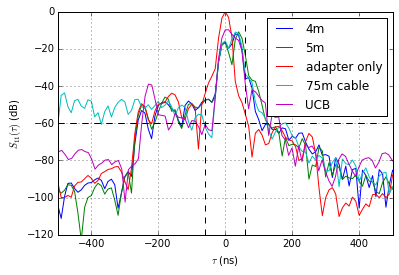

In [19]:
plt.plot(delays*1e9,2*10.*np.log10(rFunction4m),label='4m')
#plt.plot(delays*1e9,2*10.*np.log10(rFunction4p5m),label='4.5m')
plt.plot(delays*1e9,2*10.*np.log10(rFunction5m),label='5m')
#plt.plot(delays*1e9,2*10.*np.log10(rFunction5p3m),label='5.3m')
plt.plot(delays*1e9,2*10.*np.log10(rFunctionAdapt),label='adapter only')
plt.plot(delays*1e9,2*10.*np.log10(rFunctionOld),label='75m cable')
plt.plot(delaysUCB*1e9,2*10.*np.log10(rFunctionUCB),label='UCB')






#plt.plot(delays*1e9,2*10.*np.log10(np.abs(rFunctionRect)/np.abs(rFunctionRect).max()))

plt.xlabel('$\\tau$ (ns)')
plt.ylabel('$S_{11}(\\tau)$ (dB)')
plt.xlim(-2000,2000)
plt.axhline(-60,color='k',ls='--')
plt.axvline(60,color='k',ls='--')


plt.axhline(-60,color='k',ls='--')
plt.axvline(-60,color='k',ls='--')
#for mm in range(10):
#    plt.axvline(mm*28,color='k',ls='-')
#plt.plot(delays*1e9,-.6*delays*1e9)
plt.xlim(-500,500)
plt.ylim(-120,0)
#plt.gca().set_xticks(np.arange(-30,300,30))
plt.grid()
plt.legend(loc='best')
#plt.gcf().set_size_inches(20,10)
#plt.savefig('s11_feedAndDish_Oct21_2015.pdf')

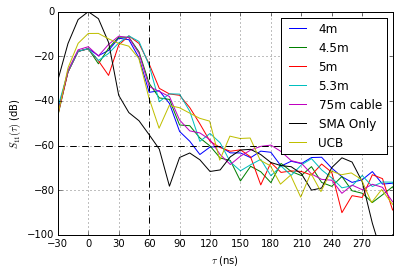

In [20]:
plt.plot(delays*1e9,2*10.*np.log10(rFunction4m),label='4m')
plt.plot(delays*1e9,2*10.*np.log10(rFunction4p5m),label='4.5m')
plt.plot(delays*1e9,2*10.*np.log10(rFunction5m),label='5m')
plt.plot(delays*1e9,2*10.*np.log10(rFunction5p3m),label='5.3m')
plt.plot(delays*1e9,2*10.*np.log10(rFunctionOld),label='75m cable')
plt.plot(delays*1e9,2*10.*np.log10(rFunctionAdapt),label='SMA Only',color='k')
plt.plot(delaysUCB*1e9,2*10.*np.log10(rFunctionUCB),label='UCB')






#plt.plot(delays*1e9,2*10.*np.log10(np.abs(rFunctionRect)/np.abs(rFunctionRect).max()))

plt.xlabel('$\\tau$ (ns)')
plt.ylabel('$S_{11}(\\tau)$ (dB)')
plt.xlim(-2000,2000)
plt.axhline(-60,color='k',ls='--')
plt.axvline(60,color='k',ls='--')


plt.axhline(-60,color='k',ls='--')
plt.axvline(-60,color='k',ls='--')
#for mm in range(10):
#    plt.axvline(mm*28,color='k',ls='-')
#plt.plot(delays*1e9,-.6*delays*1e9)
plt.xlim(-30,300)
plt.ylim(-100,0)
plt.gca().set_xticks(np.arange(-30,300,30))
plt.grid()
plt.legend(loc='best')
#plt.gcf().set_size_inches(20,10)
#plt.savefig('s11_closeup_feedAndDish_Oct21_2015.pdf')